In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

from scipy.stats import rv_histogram

import nice
from nice.reload import deep_reload

In [ ]:
'''
Creating an atlas
'''
deep_reload(nice)

rng = np.random.default_rng(26893751)

kw = {
    'rng': rng,
    'xlim': (0, 1e6),
    'ylim': (0, 1e6),
    'create_using': nx.DiGraph
}

atlas = nice.graph.nmu_graph(100, 3, **kw)

for source, _adj in atlas._adj.items():

    atlas._node[source]['population'] = 10 ** rng.uniform(2, 6) / 1e6
    
    for target, edge in _adj.items():

        speed = rng.uniform(65, 65) * 1609 / 3600
        edge['time'] = edge['distance'] / speed
        edge['energy'] = 500 * edge['distance']
        edge['ac_time'] = edge['time'] + edge['energy'] / 6.6e3

'''
Selecting places and stations
'''
deep_reload(nice)

n_places = 15
n_stations = 45

rng = np.random.default_rng(26589763514)

places = list(
    rng.choice(atlas.nodes, replace = False, size = n_places)
)

stations = list(
    rng.choice(
        list(set(atlas.nodes) - set(places)), replace = False, size = n_stations
    )
)

In [2]:
'''
Creating an atlas
'''
deep_reload(nice)

rng = np.random.default_rng(26893751)

scale = .5e6

nodes = [
    (0, {'x': 0 * scale, 'y': 0, 'population': 1}),
    (1, {'x': .25 * scale, 'y': .25 * scale}),
    (2, {'x': .5 * scale, 'y': .5 * scale}),
    (3, {'x': .75 * scale, 'y': .75 * scale}),
    (4, {'x': 1 * scale, 'y': 1 * scale, 'population': 1}),
]

d = np.sqrt(.25 ** 2 + .25 ** 2) * scale

edges = [
    (0, 1, {'distance': d}),
    (1, 2, {'distance': d}),
    (2, 3, {'distance': d}),
    (3, 4, {'distance': d}),
]

atlas = nx.Graph()
atlas.add_nodes_from(nodes)
atlas.add_edges_from(edges)
atlas = nx.DiGraph(atlas)

for source, _adj in atlas._adj.items():
    for target, edge in _adj.items():

        speed = rng.uniform(65, 65) * 1609 / 3600
        edge['time'] = edge['distance'] / speed
        edge['energy'] = 500 * edge['distance']

'''
Selecting places and stations
'''

places = [0, 4]
stations = [1, 2, 3]

In [31]:
'''
Creating a Vehicle
'''
deep_reload(nice)

kw = {
    'capacity': 75 * 3.6e6,
    'fields': ['time', 'distance', 'energy']
}

vehicle = nice.optimization.Vehicle(**kw)

graph = vehicle.transform(atlas, places + stations)

In [32]:
deep_reload(nice)

paths = nice.optimization.get_paths(
    graph, terminals = places, k = 25, weight = 'time',
)

 [------------>] (2/2) 100.00%, 2407.75 it/s, 0.00 s elapsed, 0.00 s remaining

In [33]:
paths

[{'origin': 0, 'destination': 4, 'index': 0, 'path': [0, 1, 4]},
 {'origin': 0, 'destination': 4, 'index': 1, 'path': [0, 2, 4]},
 {'origin': 0, 'destination': 4, 'index': 2, 'path': [0, 1, 2, 4]},
 {'origin': 0, 'destination': 4, 'index': 3, 'path': [0, 3, 4]},
 {'origin': 0, 'destination': 4, 'index': 4, 'path': [0, 2, 3, 4]},
 {'origin': 0, 'destination': 4, 'index': 5, 'path': [0, 1, 3, 4]},
 {'origin': 0, 'destination': 4, 'index': 6, 'path': [0, 1, 2, 3, 4]},
 {'origin': 4, 'destination': 0, 'index': 0, 'path': [4, 1, 0]},
 {'origin': 4, 'destination': 0, 'index': 1, 'path': [4, 2, 0]},
 {'origin': 4, 'destination': 0, 'index': 2, 'path': [4, 3, 0]},
 {'origin': 4, 'destination': 0, 'index': 3, 'path': [4, 2, 1, 0]},
 {'origin': 4, 'destination': 0, 'index': 4, 'path': [4, 3, 1, 0]},
 {'origin': 4, 'destination': 0, 'index': 5, 'path': [4, 3, 2, 0]},
 {'origin': 4, 'destination': 0, 'index': 6, 'path': [4, 3, 2, 1, 0]}]

In [34]:
'''
Places
'''
deep_reload(nice)

p = [ 0.00890009, -0.00686443]
f = lambda d: p[0] * np.exp(p[1] * d)

kw = {
    'routing_weight': 'time',
    'production': 'population',
    # 'friction_function': lambda x: 1,
}

graph = nice.demand.demand(graph, places, **kw)

In [35]:
graph._node

{0: {'x': 0.0,
  'y': 0,
  'population': 1,
  'cost': 24339.861474126992,
  'flows': {4: 0.5},
  'direct': {4: 24339.861474126992}},
 4: {'x': 500000.0,
  'y': 500000.0,
  'population': 1,
  'cost': 0,
  'flows': {0: 0.5},
  'direct': {0: 24339.861474126992}},
 1: {'x': 125000.0, 'y': 125000.0, 'cost': 18254.896105595246},
 2: {'x': 250000.0, 'y': 250000.0, 'cost': 12169.930737063496},
 3: {'x': 375000.0, 'y': 375000.0, 'cost': 6084.965368531748}}

In [54]:
'''
Stations
'''
deep_reload(nice)

rng = np.random.default_rng(26589763514)

energy = 35 * 3.6e6
power = 80e3
m = 1 / (energy / power)
rho = np.concatenate((np.linspace(0, .8, 2), np.linspace(.81, .99, 20)))
c = np.arange(0, 41, 1)

queue = nice.queue.Queue(m = m)
volumes = np.array([rho * m * size for size in c])
delays =  np.array(
    [queue.interpolate(rho, size)[0] * rho * m * size for size in c]
)

for station in stations:

    graph._node[station]['power'] = power
    graph._node[station]['volumes'] = np.atleast_2d(volumes)
    graph._node[station]['delays'] = np.atleast_2d(delays * volumes)
    graph._node[station]['expenditures'] = c

In [69]:
'''
Adding classes
'''
deep_reload(nice)

for place in places:

    graph._node[place]['_class'] = nice.optimization.Place

for station in stations:

    graph._node[station]['_class'] = nice.optimization.Station

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['_class'] = nice.optimization.Edge

for path in paths:
    
    path['_class'] = nice.optimization.Path

In [70]:
'''
Building the network
'''
deep_reload(nice)

kw = {
    'verbose': True,
}

network = nice.optimization.Network(**kw).from_graph(graph, paths)

network.build()

Sets Built: 0.0030968189239501953
Parameters Built: 0.0009477138519287109
Variables Built: 0.005000114440917969
4 0.5
'0_4_0::volume' + '0_4_1::volume' + '0_4_2::volume' + '0_4_3::volume' + '0_4_4::volume' + '0_4_5::volume' + '0_4_6::volume'
0 0.5
'4_0_0::volume' + '4_0_1::volume' + '4_0_2::volume' + '4_0_3::volume' + '4_0_4::volume' + '4_0_5::volume' + '4_0_6::volume'
Constraints Built: 0.013234615325927734
Expenditure Built: 0.0001800060272216797
Objective Built: 0.0002894401550292969


In [122]:
'''
Solving the model
'''
deep_reload(nice)

kw = {
    'solver': {
        '_name': 'cbc',
        # '_name': 'appsi_highs',
        'time_limit': 10 * 6,
        # 'sec': 10,
        # 'ratio': .000001,
    },
}

network.model.scale = 15 / 3600
network.model.expenditure = 40
network.model.expenditure_cost = 50 * 0
network.solve(**kw)
solution = network.solution
solution = nice.optimization.solution_atlas(
    network.solution, atlas, fields = ['volume']
)

Problem Solved: 0.12253689765930176
Results Collected: 0.0014486312866210938


In [123]:
import pyomo.environ as pe

pe.value(network.model.objective)

0.00097901415

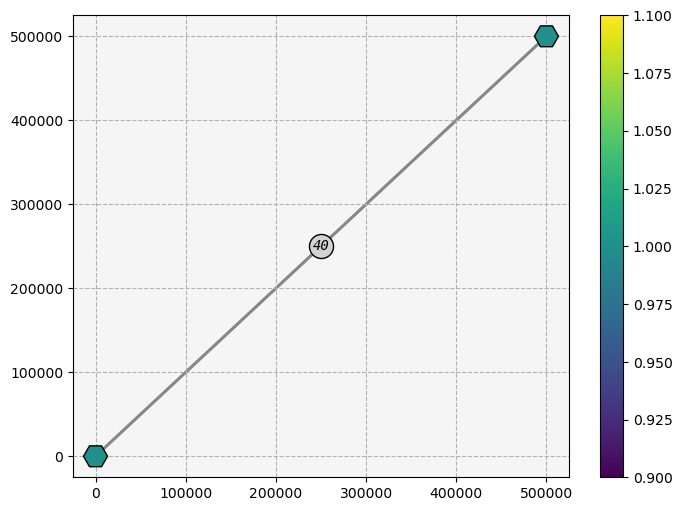

In [124]:
deep_reload(nice)

fig, ax = plt.subplots(figsize = (8, 6))

eps = 0

s_nodes = [k for k, n in solution._node.items() if n.get('volume', 0) > 0]
s_nodes = [k for k, n in solution._node.items() if n.get('selection', 0) > 0]
s_edges = (
    [(s, t) for s, a in solution._adj.items() \
     for t, e in a.items() if e.get('volume', 0) > eps]
)

for source, node in solution._node.items():

    node['volume_h'] = node.get('volume', 0) * 3600

kw = {
    'nodes': {
        'selection': s_nodes,
        'plot': {
            's': 300,
            'zorder': 2,
            'ec': 'k',
            'fc': 'lightgray',
        },
    },
    'edges': {
        'field': 'volume',
        'selection': s_edges,
        'cmap': nice.plot.Colormap(['#888888', '#000000']),
        'plot': {
            'lw': 2,
            'color': 'gray',
            'zorder': 1,
        },
    },
}
    
sm = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'nodes': {
        'selection': list(places),
        'field': 'population',
        # 'multiple': 1e6,
        'colorbar': {},
        'plot': {
            's': 300,
            'fc': 'k',
            'ec': 'k',
            'zorder': 3,
            'marker': 'H',
        },
    },
    'edges': {
        'plot': {
            'lw': 1,
            'ls': '--',
            'color': '#dddddd',
            'zorder': 0,
        },
    },        
}
    
_ = nice.plot.plot_graph(solution, ax = ax, **kw)

kw = {
    'plot': {
        'horizontalalignment': 'center',
        'verticalalignment': 'center',
        'fontstyle': 'italic',
        'fontweight': 'roman',
        'fontfamily': 'monospace',
    },
    'selection': s_nodes,
    'field': 'selection',
}

_ = nice.plot.plot_labels(solution, ax = ax, **kw)

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

In [115]:
[(p['path'], p['results']) for p in network.paths]

[([0, 1, 4], {'volume': 0.0}),
 ([0, 2, 4], {'volume': 0.0020833333}),
 ([0, 1, 2, 4], {'volume': 0.0}),
 ([0, 3, 4], {'volume': 0.0}),
 ([0, 2, 3, 4], {'volume': 0.0}),
 ([0, 1, 3, 4], {'volume': 0.0}),
 ([0, 1, 2, 3, 4], {'volume': 0.0}),
 ([4, 1, 0], {'volume': 0.0}),
 ([4, 2, 0], {'volume': 0.0}),
 ([4, 3, 0], {'volume': 0.0020833333}),
 ([4, 2, 1, 0], {'volume': 0.0}),
 ([4, 3, 1, 0], {'volume': 0.0}),
 ([4, 3, 2, 0], {'volume': 0.0}),
 ([4, 3, 2, 1, 0], {'volume': 0.0})]

In [111]:
1e2 / 3600 / 2

0.013888888888888888

In [16]:
s = 0

for source, node in solution._node.items():

    s += node.get('selection', 0)

s

100

In [8]:
'''
Adding classes
'''
deep_reload(nice)

rng = np.random.default_rng(26589763514)

energy = 35 * 3.6e6
power = 80e3
m = 1 / (energy / power)
rho = np.concatenate((np.linspace(0, .8, 2), np.linspace(.81, .99, 20)))
c = np.arange(0, 21, 1)

queue = nice.queue.Queue(m = m)
volumes = np.array([rho * m * size for size in c])
delays =  np.array(
    [queue.interpolate(rho, size)[0] * rho * m * size for size in c]
)

for station in stations:

    graph._node[station]['power'] = 80e3
    graph._node[station]['_class'] = nice.optimization.Station

    graph._node[station]['volumes'] = np.atleast_2d(volumes)
    graph._node[station]['delays'] = np.atleast_2d(delays * volumes) * 0
    graph._node[station]['expenditures'] = c

for source, _adj in graph._adj.items():
    for target, edge in _adj.items():

        edge['_class'] = nice.optimization.Edge

for path in paths:

    path['capacity'] = 80 * 3.6e6 / 2
    path['_class'] = nice.optimization.Path